# Post-process CSHT binning, and binning of ASC speed

Converting mean monthly CSHT(z) to CSHT($\sigma_0$).  The aim is to evaluate if we should recalculate all the correlations, and speeds in $\sigma_0$, and to evaluate what does that tells us

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
from tqdm import tqdm

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=56, memory_limit='380GiB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 56
Total threads: 56,Total memory: 20.78 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45231,Workers: 56
Dashboard: /proxy/8787/status,Total threads: 56
Started: Just now,Total memory: 20.78 TiB
Comm: tcp://127.0.0.1:34775,Total threads: 1
Dashboard: /proxy/37471/status,Memory: 380.00 GiB
Nanny: tcp://127.0.0.1:34669,


In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*').resample(time='1M').mean()
u_along_unbinned = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/OM2_IAF/*').resample(time='1M').mean()
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*').resample(time='1M').mean()

In [ ]:
# importing it
MT = xr.open_mfdataset('/g/data/e14/cs6673/iav_AABW/data_iav_AABW_final/vol_trans_across_contour_01deg_jra55v140_iaf_cycle3_1d*').resample(time='1M').mean()
MT=MT.vol_trans_across_contour.load()

In [4]:
# unbinned CSHT monthly
unbinned_heat_transp_across_contour = CSHT_along.unbinned_heat_transp_across_contour
lon_along_contour = CSHT_along.lon_along_contour.isel(st_ocean=0,time=0).drop_vars(('st_ocean','time'))
lat_along_contour = CSHT_along.lat_along_contour.isel(st_ocean=0,time=0).drop_vars(('st_ocean','time'))

# unbinned CSHT
u_along_unbinned_monthly = u_along_unbinned.u_along_contour

In [5]:
#importing rho0
session = cc.database.create_session()
exp = '01deg_jra55v140_iaf_cycle3'
lat_range = slice(-90,-59)
rho0 = cc.querying.getvar(exp,'pot_rho_0',session,frequency = '1 monthly').sel(yt_ocean=lat_range)
yu_ocean=cc.querying.getvar(exp,'yu_ocean',session,n=1).sel(yu_ocean=lat_range)
xu_ocean=cc.querying.getvar(exp,'xu_ocean',session,n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

Reminder: lon and lat along contour are not on central  T-points, but on u points. So you will have to interpolate density into those lateral points

In [6]:
#interpoalting rho into the correct grid point
rho0_u=rho0.interp(xt_ocean=xu_ocean)
rho0_v=rho0.interp(yt_ocean=yu_ocean)

lets extract the densities along the contour

In [7]:
########### Import Adeles 1km contour on X,Y grid                
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
cutout_latind = 510
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']; 
mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
mask_x_transport = data['mask_x_transport']; 
mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
mask_x_transport_numbered = data['mask_x_transport_numbered']
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################


#cutting the matrices
ylength= np.shape(mask_x_transport)[0]


yt_ocean0 = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
yu_ocean0 = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
xt_ocean0 = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean0 = cc.querying.getvar(exp,'xu_ocean',session,n=1)

mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_x_transport=mask_x_transport[:cutout_latind,:]       ##############################
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_y_transport=mask_y_transport[:cutout_latind,:]		################################		
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################		
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))                
	
	
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)
	

In [8]:

x_along_1d = rho0_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = rho0_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)


In [9]:
## first time run this should be uncommented
# x_along_1d.load()
# y_along_1d.load()

# rho0_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
# rho0_contour = rho0_contour.sortby(contour_ordering)
# rho0_contour.coords['contour_index'] = contour_index_array
# rho0_contour = rho0_contour

In [22]:
#getting the surface area along the contour for averaging U data
tarea = cc.querying.getvar(exp,'area_t',session,n=1).sel(yt_ocean=lat_range)
tarea_u=tarea.interp(xt_ocean=xu_ocean)
tarea_v=tarea.interp(yt_ocean=yu_ocean)

#getting contours of tarea
x_along_1d = tarea_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = tarea_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

x_along_1d.load()
y_along_1d.load()

tarea_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
tarea_contour = tarea_contour.sortby(contour_ordering)
tarea_contour.coords['contour_index'] = contour_index_array



In [103]:
#loading saved rho0
#rho0_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')

#### Transfering CSHT into $\sigma_0$ bins

In [104]:
##creating the target bins
# targetbins = cc.querying.getvar(exp, 'potrho_edges', session, n = 1, frequency = '1 monthly').values
#targetbins = np.linspace(np.round(rho0_contour.pot_rho_0.min().values-2),np.round(rho0_contour.pot_rho_0.max().values+2),80)
#targetbins = np.append(np.append(1020,np.linspace(1023,rho0_contour.pot_rho_0.max().values+0.2,100)),1030)
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)
#targetbins = np.append(np.append(1022,np.linspace(1026,np.round(rho0_contour.pot_rho_0.max().values),40)),np.round(rho0_contour.pot_rho_0.max().values+2))
# targetbins = np.append(np.append(np.append(1022,np.linspace(1026,1027,30, endpoint=False)),\
#                                  np.linspace(1027,np.round(rho0_contour.pot_rho_0.max().values),40))\
#                        ,np.round(rho0_contour.pot_rho_0.max().values+2))


In [105]:
np.shape(targetbins)

(109,)

In [106]:
unbinned_heat_transp_across_contour.load()

<xarray.DataArray 'unbinned_heat_transp_across_contour' (time: 732,
                                                         st_ocean: 75,
                                                         contour_index: 6002)> Size: 1GB
array([[[-3.6926989e+09, -3.1486413e+09, -2.1758989e+09, ...,
         -4.1019341e+09, -6.2795699e+08, -7.0186360e+07],
        [-3.9664092e+09, -3.4078282e+09, -2.3573796e+09, ...,
         -4.4292454e+09, -6.1890022e+08, -1.0628083e+09],
        [-4.2976000e+09, -3.7325750e+09, -2.6055183e+09, ...,
         -4.8460631e+09, -6.7971622e+08, -1.7446577e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.5132155e+09, -3.7394693e+09, -2.7558116e+09, ...,
         -3.5722534e+09, -3.3919816e+09,  9.2795750e+09],
        [-5.4958868e+09, -4.6556554e+09, -3.5782961e+09, ...,
         -4.4416456e+09, -4.2444178e+09,  9.0425283e+09],
        [-6.3132175e+09, -5.4034284e+09, -4.2268362e+09, ...,
         -5.1444562e+09, -4.9275919e+09,  9.2108698e+09],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-1.4166273e+09, -1.5130350e+09, -1.4337480e+09, ...,
         -9.4293862e+08, -6.6708474e+08,  2.6811044e+09],
        [-1.8034785e+09, -1.9292154e+09, -1.8522167e+09, ...,
         -1.2586666e+09, -9.5047181e+08,  2.4625948e+09],
        [-2.1578299e+09, -2.3104950e+09, -2.2334313e+09, ...,
         -1.5219793e+09, -1.1837548e+09,  2.3025091e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * st_ocean       (st_ocean) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
    TLON           (contour_index) float32 24kB 80.05 80.15 ... 79.95 79.95
    TLAT           (contour_index) float32 24kB -66.03 -66.03 ... -66.07 -66.03
    ULON           (contour_index) float32 24kB -279.9 -279.8 ... 80.0 80.0
    ULAT           (contour_index) float32 24kB -66.01 -66.01 ... -66.05 -66.01
  * time           (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

Now apply the histogram over the vertical dimension st_ocean inside the target bins.

In [107]:
from xhistogram.xarray import histogram

In [108]:
#correcting rho0 time so it is equal for the histogram method
rho0_contour['time']=unbinned_heat_transp_across_contour.time

In [109]:
rho0_contour = rho0_contour.pot_rho_0

In [110]:
CSHT_mean = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = unbinned_heat_transp_across_contour).rename({rho0_contour.name + '_bin': 'potrho0'})

sanity check

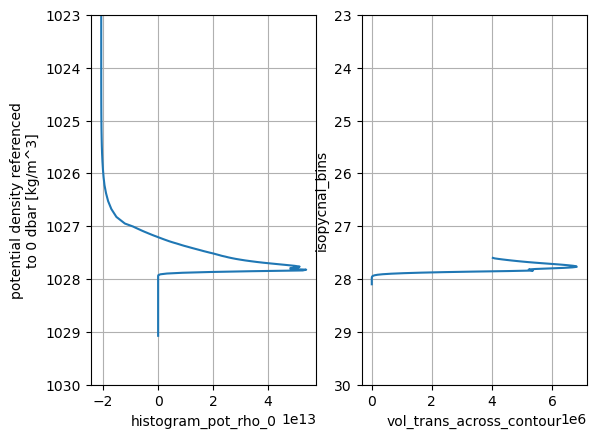

In [111]:
plt.subplot(1,2,1)
CSHT_mean.mean('time').sum('contour_index')[::-1].cumsum().plot(y='potrho0')
plt.ylim(1030,1023); plt.grid()
plt.subplot(1,2,2)
MT.mean('time').sum('contour_index')[::-1].cumsum().plot(y='isopycnal_bins')
plt.ylim(30,23); plt.grid()

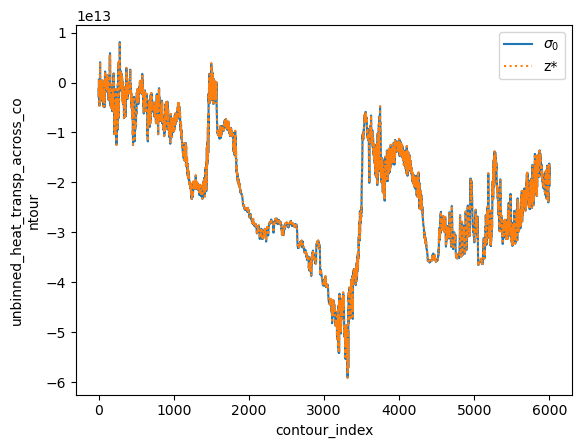

In [112]:
CSHT_mean.mean('time').sum('potrho0').cumsum().plot(label=r'$\sigma_0$')
unbinned_heat_transp_across_contour.mean('time').sum('st_ocean').cumsum().plot(linestyle=':',label='z*')
plt.legend()

(1028.5, 1022.0)

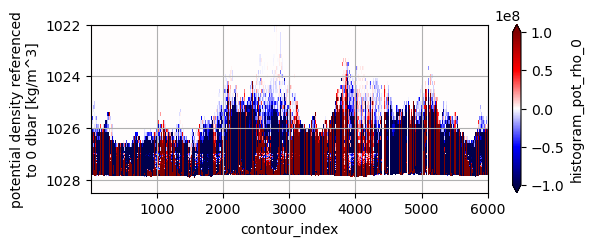

In [113]:
#Plotting the contour with a crazy colorbar, so We can see if the upper density levels match
# the U data plotted below
plt.subplot(2,1,1)
CSHT_mean.mean('time').plot(y='potrho0',cmap='seismic',vmin=-1e8,vmax=1e8)
plt.ylim(1030,1020); plt.grid(); plt.ylim(1028.5,1022)

total heat transport is negative, and the curve is reasonably smooth, and the vertically integrated curve looks a lot like the curve for the CSHT(z) data.

In [84]:
# # saving the mean monthly CSHT along potrho0
# CSHT_mean.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/CSHT_rho0_along_contour.nc')

In [114]:
#rebinning the ASC speed
u_along_unbinned_monthly.load()
U_mean = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = u_along_unbinned_monthly*tarea_contour).rename({rho0_contour.name + '_bin': 'potrho0'})/\
                          histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = tarea_contour).rename({rho0_contour.name + '_bin': 'potrho0'})

U_mean.name='U_along_contour'

Sainity check on Ualong

(1250.0, 0.0)

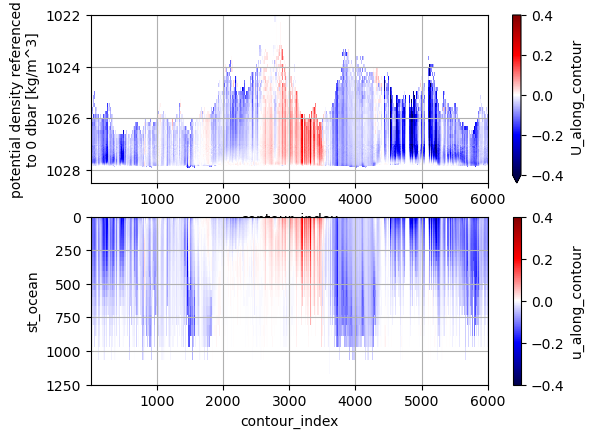

In [116]:
plt.subplot(2,1,1)
U_mean.mean('time').plot(y='potrho0',cmap='seismic',vmin=-0.4,vmax=0.4)
plt.ylim(1030,1020); plt.grid(); plt.ylim(1028.5,1022)
plt.subplot(2,1,2)
u_along_unbinned_monthly.mean('time').plot(y='st_ocean',cmap='seismic',vmin=-0.4,vmax=0.4)
plt.grid();  plt.ylim(1250,0)

Velocity contour looks reasonably similar to me.

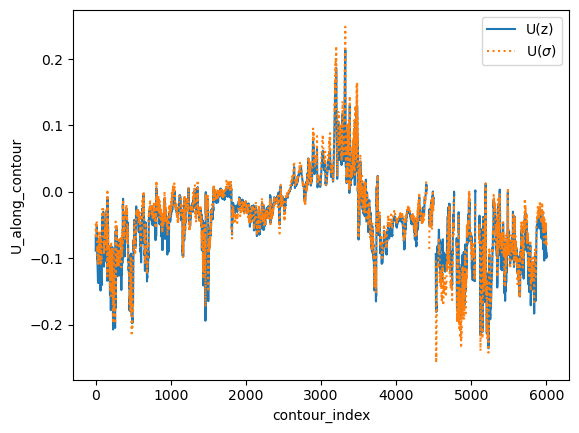

In [117]:
u_along_unbinned_monthly.mean('time').mean('st_ocean').plot(label='U(z)')
U_mean.mean('time').mean('potrho0').plot(linestyle=':',label=r'U($\sigma$)')
plt.legend()

ASC speed along contour in sigma looks resonably similar to the original in z too

In [118]:
#saving the mean monthly U along potrho0
U_mean.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/Ualong_rho0_along_contour.nc')

## 3-degrees binning

Now that we have the monthly CSHT and along-slope speed in f(sigma), we can rebin the data into the classing 3 degrees bin.

In [119]:
lat_along_contour = np.array(lat_along_contour)
lon_along_contour = np.array(lon_along_contour)

In [120]:
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 3
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	n_bin_edges = len(full_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(n_bin_edges)
	for lon_bin in range(n_bin_edges-1):
		# find first isobath point that has the right longitude:
		first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
		# then find all other isobath points with the same longitude as that first point:
		same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
		# we want the most southerly of these points on the same longitude line:
		bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
		
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
		# find nearest isobath point:
		lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
		lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
	

In [121]:
#transposing for posterior use of indexes
CSHT_mean = CSHT_mean.transpose("time", "potrho0", "contour_index")
U_mean = U_mean.transpose("time", "potrho0", "contour_index")

Notice that we want to compare the CSHT binned with the massk transport, in each regime region. but for that we need to import the mass transports from the IAF simulation, and bin it into the same longitude bins as the CSHT. this will help us define the best $\sigma_0$ for the CDW in each shelf regime

In [122]:
# sum heat transport from isobath coord into new longitude coord:
nmonths=732
cross_slope_heat_trans = np.zeros([nmonths,np.size(targetbins)-1,n_bins])
U_binned = np.zeros([nmonths,np.size(targetbins)-1,n_bins])
Mass_binned = np.zeros([nmonths,51,n_bins])
for lon_bin in range(n_bins):
	heat_trans_this_bin0 = CSHT_mean[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	U_this_bin0 = U_mean[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	M_this_bin0 = MT[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	cross_slope_heat_trans[:,:,lon_bin] = np.sum(heat_trans_this_bin0,axis=2)
	U_binned[:,:,lon_bin] = np.nanmean(U_this_bin0,axis=2)
	Mass_binned[:,:,lon_bin] = np.nansum(M_this_bin0,axis=2)

lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
	# find nearest isobath point:
	lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
	lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]


## CSHT vs ASC speed by regime ( Not accounting zonal convergence)

Let's use the mean mask, and calcualte the CHST profile and mean ASC speed per sigma layer, and see how these profiles look like. We can additionally calcualte the correlations and slopes. We have found taht over these large integrated areas, the zonal convergence tends to have not much effect. We will evaluate the effect of zonal convergence in the next section

In [123]:
#Importing average clustering mask
mean_mask=xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
mean_mask=mean_mask.regimes_mask.load()
mean_mask = mean_mask.rename({'lon':'lon_bin_midpoints'})
mean_mask

<xarray.DataArray 'regimes_mask' (regime: 3, lon_bin_midpoints: 1428)> Size: 34kB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * regime             (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25

In [124]:
factor = float(CSHT_mean.mean('time').sum(('potrho0','contour_index')) / np.nansum(np.nanmean(cross_slope_heat_trans,axis=0)))
factor_mass = float(MT.mean('time').sum(('isopycnal_bins','contour_index')) / np.nansum(np.nanmean(Mass_binned,axis=0)))

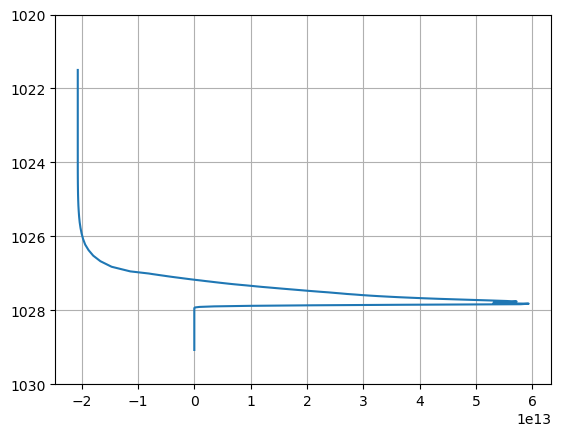

In [125]:
plt.plot(np.cumsum(np.nansum(np.nanmean(cross_slope_heat_trans,axis=0),axis=1)[::-1])*factor,CSHT_mean.potrho0[::-1])
plt.ylim(1030,1020); plt.grid()

lets create an xarray with CSHT

In [126]:
data_CSHT=xr.DataArray((cross_slope_heat_trans),name="binned_cross_slope_heat_trans",dims=["time","potrho0","lon_bin_midpoints"])
data_CSHT['potrho0']=np.array(CSHT_mean.potrho0)
data_CSHT['lon_bin_midpoints']=lon_bin_midpoints
data_CSHT['time']=CSHT_mean.time


In [127]:
data_M=xr.DataArray((Mass_binned),name="binned_mass_transport",dims=["time","isopycnal_bins","lon_bin_midpoints"])
data_M['isopycnal_bins']=np.array(MT.isopycnal_bins)
data_M['lon_bin_midpoints']=lon_bin_midpoints
data_M['time']=CSHT_mean.time

MT_masked = data_M*mean_mask*factor_mass

In [128]:
CSHT_masked = data_CSHT*mean_mask*factor

In [129]:
R0_1 = (CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R0_2 = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R0 = np.append(R0_1,R0_2[::-1])
depthfill = np.append(R0_1.st_ocean,R0_1.st_ocean[::-1])

R1_1=(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R1_2 = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R1 = np.append(R1_1,R1_2[::-1])

R2_1 = (CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R2_2  = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R2 = np.append(R2_1,R2_2[::-1])

Text(0.5, 0, 'Upwards cumulative sum [$W$]')

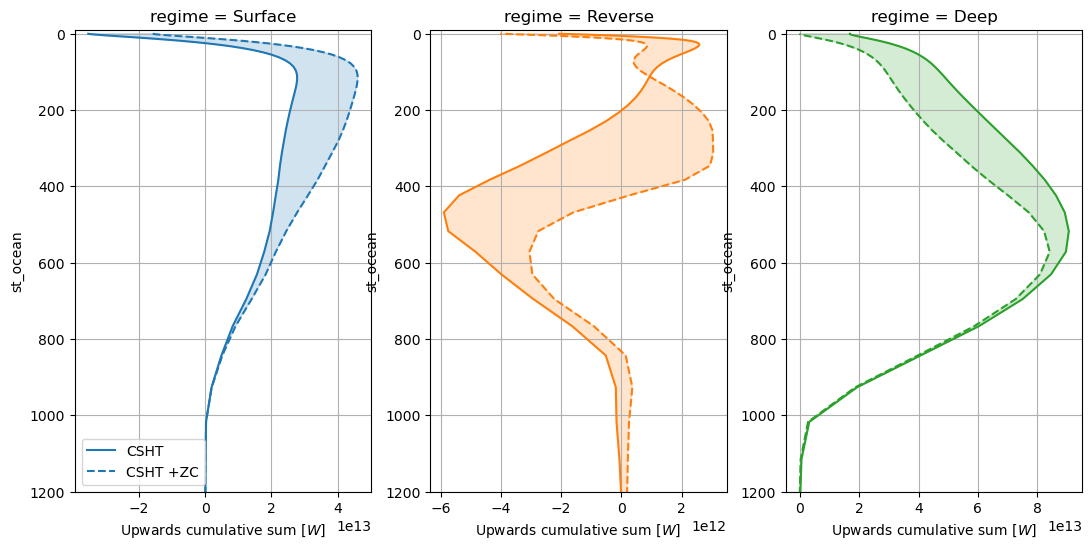

In [130]:
plt.figure(figsize=(13,6))


ax = plt.subplot(1,3,1)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:blue',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:blue',label='CSHT +ZC')
plt.fill(R0,depthfill,color='tab:blue',alpha=0.2)
plt.legend(); plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

plt.subplot(1,3,2)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:orange',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:orange',label='CSHT +ZC')
plt.fill(R1,depthfill,color='tab:orange',alpha=0.2)
plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

plt.subplot(1,3,3)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:green',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:green',label='CSHT +ZC')
plt.fill(R2,depthfill,color='tab:green',alpha=0.2)
plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

The plot above shows the upwards cumulative sum of CSHT separate for the CSHT+ZC in a mean of the deep regimes bins. Notice that without the ZC, the total CSHT in these regions is negative. Now, the zonal covnergence helps closing the budget in this region especially at the surface. Since the ZC is the sum of all the heat transports from the shelf break i to the coast, that means that <font color='green'> heat leaving the shelf through DSW formation in Dense shelf regime is being compensated by heat coming from other regimes. And since this heat is already south of the 1km isobath, it would already be acessing the shelf. </font> 

<font color='blue'> We can also see that while all regimes are gaining heat from zonal convergence, the only one loosing heat by zonal convergence is the surface regime. Which suggests that this regime actually imports heat to the shelf, and the export to DSW locations </font> 

Text(0.5, 0, '$m^3\\ s^{-1}$')

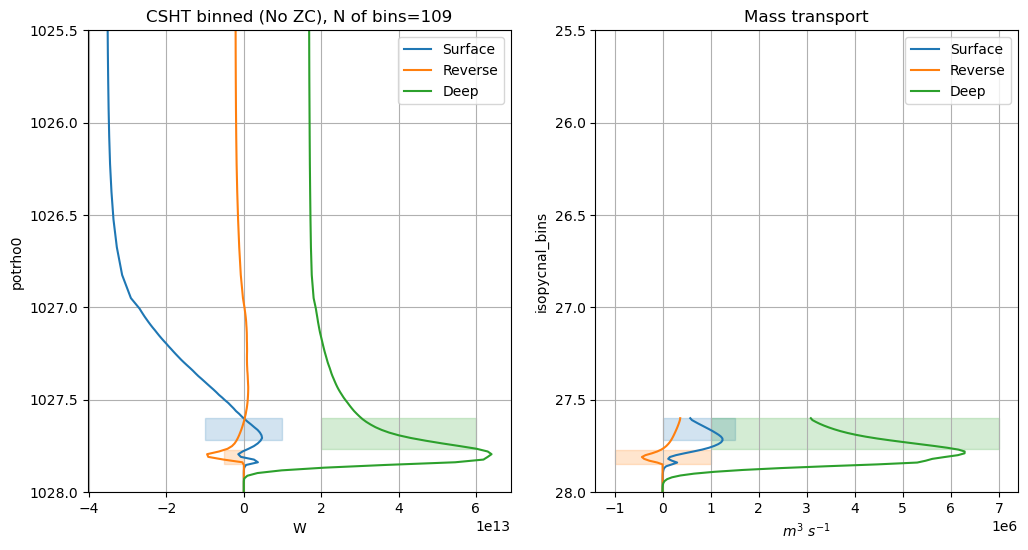

In [131]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

CSHT_masked.isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Surface')
plt.fill([-1e13,1e13,1e13,-1e13],[1027.72,1027.72,1027.6,1027.6],color='tab:blue',alpha=0.2)
CSHT_masked.isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Reverse')
plt.fill([-.5e13,0,0,-.5e13],[1027.85,1027.85,1027.77,1027.77],color='tab:orange',alpha=0.2)
CSHT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Deep')
plt.fill([2e13,6e13,6e13,2e13],[1027.765,1027.765,1027.6,1027.6],color='tab:green',alpha=0.2)
plt.ylim(1028,1025.5); plt.grid(); plt.legend(); plt.title('CSHT binned (No ZC), N of bins='+str(np.size(targetbins)))
plt.xlabel('W')

plt.subplot(1,2,2)
MT_masked.isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Surface'); 
plt.fill([0,1.5e6,1.5e6,0],[27.72,27.72,27.6,27.6],color='tab:blue',alpha=0.2)
MT_masked.isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Reverse')
plt.fill([-1e6,1e6,1e6,-1e6],[27.85,27.85,27.77,27.77],color='tab:orange',alpha=0.2)
MT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Deep')
plt.fill([1e6,7e6,7e6,1e6],[27.765,27.765,27.6,27.6],color='tab:green',alpha=0.2)
plt.ylim(28,25.5); plt.grid(); plt.legend(); plt.title('Mass transport')
plt.xlabel(r'$m^3\ s^{-1}$')

The plot shows that at deep regime locations, the CSHT is positive, and northwards. this is not accounting for the zonal convergence tho. The zonal covnergence however compensates for this northward transport, and make the total here southward ~0... 


<font color='orange'> More interestingly, there is a clear southward transpor in very deep layers in the reverse regime, at $\sigma_0~1027.8$ . These are layers simlar to the one where DSW is exported. So it seems to me taht a combination of that heat coming from $\sigma_0~1027.8$ on reverse regime + the one coming at lighter layers in the deep regime is what actually is importing the heat</font> 

Based on the plots, it seems that the transports in sigma layers are very consitent to the the Water mass transports, which would help us understand better the CSHT of CDW. This is a motivation for us to rebin our CSHT into density layers